In [57]:
#Title: Energy forecasting using LSTM Networks
#Author: Arslan Ahmed (arslan.m.ahmed@gmail.com)
#Date: 2nd March, 2018

#import all packages that we may need

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.cross_validation import KFold # use for cross validation
from sklearn import preprocessing # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import ExtraTreesClassifier
from scipy import signal

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from pandas import concat
import matplotlib.dates as md
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

In [58]:
#function to convert time series data to apply supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [111]:
#read energy data

df_e = pd.read_csv('UKdata_energy.csv', parse_dates={'time_e' : ['Time']}, infer_datetime_format=True, na_values=['nan','?'], index_col='time_e')

In [112]:
#read weather data

df_w = pd.read_csv('UKdata_weather.csv', parse_dates={'time_w' : ['time']}, infer_datetime_format=True, na_values=['nan','?'], index_col='time_w')

In [113]:
#select data from 1st Jan 2013 to 28th Feb 2014
df_e=df_e['2013-01-01':'2014-02-28']
df_w=df_w['2013-01-01':'2014-02-28']

In [114]:
df_w=df_w.resample('30min').mean()
df_e=df_e.resample('30min').mean()

In [115]:
df = pd.concat([df_e, df_w], axis=1, join='inner')

In [116]:
df=df.interpolate(method='linear')

In [117]:
# df['Day of week'] = df.index.weekday.astype(int)
# df["Weekend"] = (df["Day of week"] > 5).astype(int)
df.iloc[:,0:3] *= 1000

In [118]:
no_of_features=len(df.columns)

In [119]:
#removing outliers
df[df.D0009 > df.D0009.quantile(.9)]=np.nan #data above 90 percentile will be filled with NaN
df[df.D0664 > df.D0664.quantile(.9)]=np.nan
df[df.D0935 > df.D0935.quantile(.9)]=np.nan
df=df.fillna(method='pad')

In [120]:
# another sanity check to make sure that there are no nan
df.isnull().sum()

D0009                  0
D0664                  0
D0935                  0
visibility             0
windBearing            0
temperature            0
dewPoint               0
pressure               0
apparentTemperature    0
windSpeed              0
humidity               0
dtype: int64

In [121]:
#drop features that are correlated with each other
df=df.drop(df.columns[[0,6,8]], axis=1)
#df=df.drop(df.columns[1:], axis=1)

In [122]:
#revised no. of features after dropping correlated features
no_of_features=len(df.columns)

In [123]:
#data scaling from 0 to 1 of original data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

In [124]:
no_of_timesteps=1
reframed = series_to_supervised(scaled, no_of_timesteps, 1)
# print(reframed.head())

In [125]:
# drop columns we don't want to predict
col_array=np.arange(0,len(reframed.columns))
reframed=reframed.loc[:,(col_array<no_of_features*no_of_timesteps+1) | (col_array%(no_of_features)==0)]

In [126]:
n_train_time = 2*24*84; # hours used for training.....
original_n_train_time=n_train_time;
pred_list=[]; #predicted values that will replace the original test_y values
testing_rows=2*24*4;#hours to predict
#testing_rows=reframed.shape[0]-original_n_train_time-1
test1 = reframed.values[n_train_time:n_train_time+testing_rows, :] #original testing data, this will later be modified with the predicted data generated by for loop
test_y1 = test1[:, -1] #see comment in above line

In [127]:
train = reframed.values[:n_train_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
# reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], no_of_timesteps, no_of_features))
print(train_X.shape)

(4032, 8)


In [128]:
svr_rbf = SVR(kernel='rbf', C=1000, gamma=0.01);
# svr_rbf = SVR(kernel='linear', C=100);
svr_rbf.fit(train_X, train_y);


In [129]:
for j in range(0,testing_rows):
    print('Loop # ',j)
    test = reframed.values[n_train_time:n_train_time+1, :]
    test_X = test[:, :-1]
#     test_X = test_X.reshape((test_X.shape[0], no_of_timesteps, no_of_features))
    yhat = svr_rbf.predict(test_X)
    for k in range(0,len(reframed.columns),no_of_features):
        if((k+no_of_features)<(len(reframed.columns)-1)):
            reframed.values[n_train_time+1,k]=reframed.values[n_train_time,(k+no_of_features)];
    reframed.values[n_train_time+1,(len(reframed.columns)-1-no_of_features)]=yhat;
#     reframed.values[n_train_time+1,0]=yhat;
    n_train_time=n_train_time+1
    pred_list=np.append(pred_list,yhat)
#     print(reframed[n_train_time-1:n_train_time])
#     print(yhat)
n_train_time=original_n_train_time

Loop #  0
Loop #  1
Loop #  2
Loop #  3
Loop #  4
Loop #  5
Loop #  6
Loop #  7
Loop #  8
Loop #  9
Loop #  10
Loop #  11
Loop #  12
Loop #  13
Loop #  14
Loop #  15
Loop #  16
Loop #  17
Loop #  18
Loop #  19
Loop #  20
Loop #  21
Loop #  22
Loop #  23
Loop #  24
Loop #  25
Loop #  26
Loop #  27
Loop #  28
Loop #  29
Loop #  30
Loop #  31
Loop #  32
Loop #  33
Loop #  34
Loop #  35
Loop #  36
Loop #  37
Loop #  38
Loop #  39
Loop #  40
Loop #  41
Loop #  42
Loop #  43
Loop #  44
Loop #  45
Loop #  46
Loop #  47
Loop #  48
Loop #  49
Loop #  50
Loop #  51
Loop #  52
Loop #  53
Loop #  54
Loop #  55
Loop #  56
Loop #  57
Loop #  58
Loop #  59
Loop #  60
Loop #  61
Loop #  62
Loop #  63
Loop #  64
Loop #  65
Loop #  66
Loop #  67
Loop #  68
Loop #  69
Loop #  70
Loop #  71
Loop #  72
Loop #  73
Loop #  74
Loop #  75
Loop #  76
Loop #  77
Loop #  78
Loop #  79
Loop #  80
Loop #  81
Loop #  82
Loop #  83
Loop #  84
Loop #  85
Loop #  86
Loop #  87
Loop #  88
Loop #  89
Loop #  90
Loop #  9

In [130]:
x_max=df.iloc[:,0].max()
x_min=df.iloc[:,0].min()
test_y1_un_scaled=test_y1*(x_max-x_min)+x_min
pred_list_un_scaled=pred_list*(x_max-x_min)+x_min

RMSE:  119.09657215758182
NRMSE:  0.15565560874775783
r2_score:  0.24179281236390904


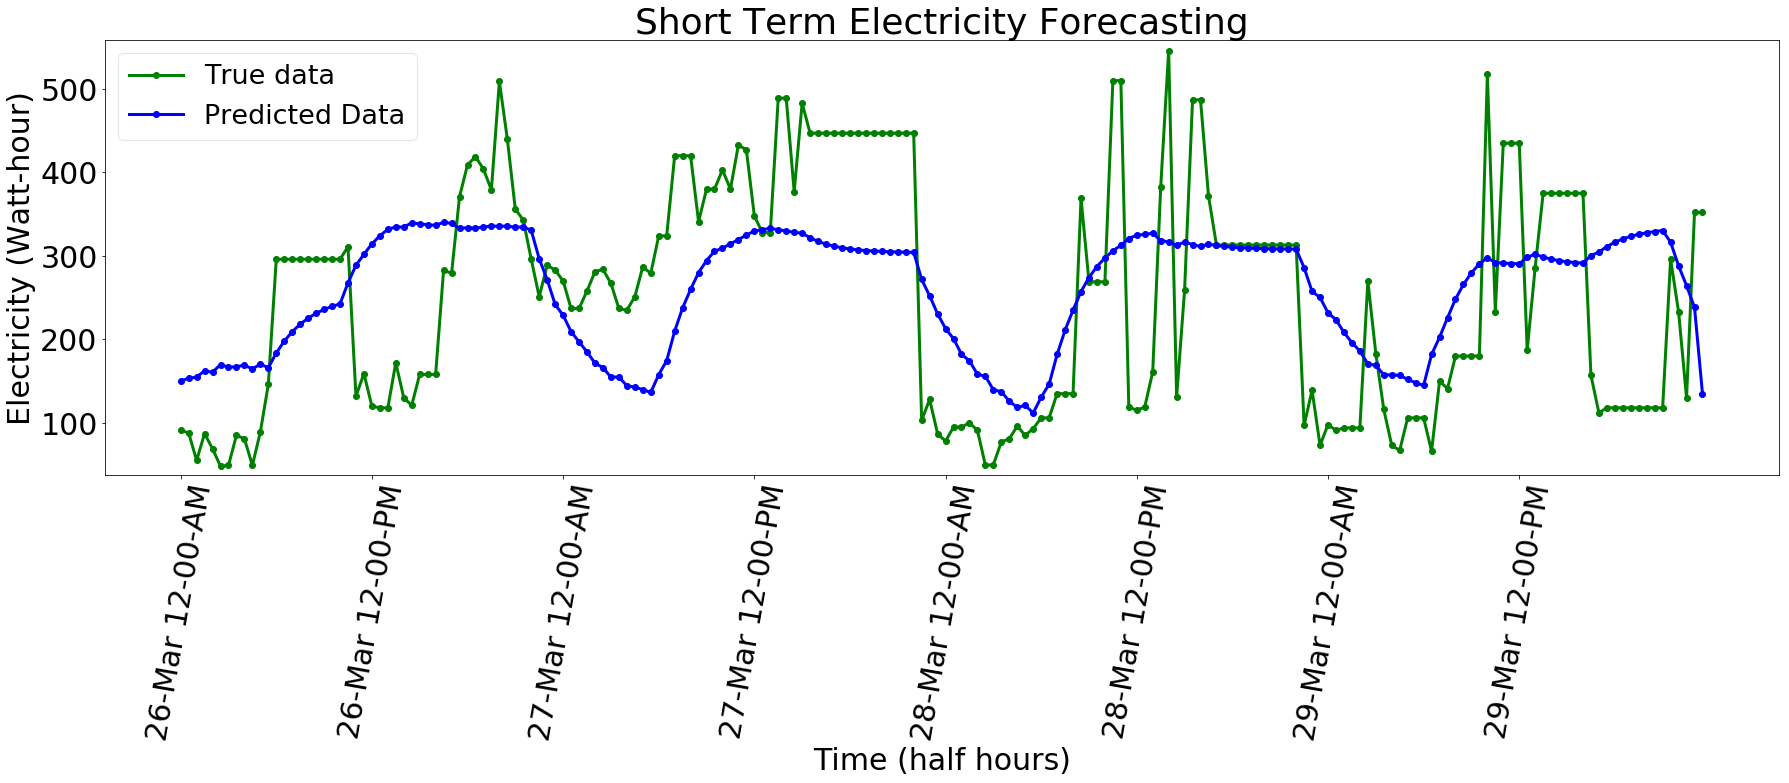

In [131]:
plt.figure(figsize=(30,8))
plt.rcParams.update({'font.size': 30})
plt.plot(test_y1_un_scaled,'go-', label='True data', linewidth=3)
plt.plot(np.roll(pred_list_un_scaled, -1),'bo-',label='Predicted Data', linewidth=3)
plt.ylabel('Electricity (Watt-hour)', fontsize=30)
plt.xlabel('Time (half hours)', fontsize=30)


x=np.arange(0,len(test_y1_un_scaled),24)
y=df.index.strftime('%d-%b %I-%M-%p')[original_n_train_time::24]
plt.xticks(x, y, rotation=80)

plt.ylim(ymin=x_min,ymax=x_max)
plt.title('Short Term Electricity Forecasting')
plt.legend(loc='upper left', fontsize=27,framealpha=0.5)
plt.savefig('5a.pdf', bbox_inches='tight')
# print ('NRMSE: ',(np.sqrt(mean_squared_error(test_y1_un_scaled, np.roll(pred_list_un_scaled, -1))))/np.mean(test_y1_un_scaled))
rmse=np.sqrt(mean_squared_error(test_y1_un_scaled, np.roll(pred_list_un_scaled, -1)))
print('RMSE: ', rmse)
print ('NRMSE: ',((rmse-x_min)/(x_max-x_min)))
from sklearn.metrics import r2_score
print ('r2_score: ', (r2_score(test_y1_un_scaled, pred_list_un_scaled)))

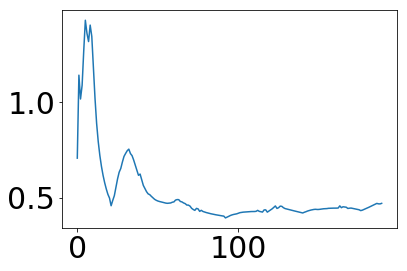

In [132]:
rmse=[];
for e in range(2,len(pred_list_un_scaled)):
    rmse.append((np.sqrt(mean_squared_error(test_y1_un_scaled[1:e], np.roll(pred_list_un_scaled[1:e], -1))))/np.mean(test_y1_un_scaled[1:e]))
#     print ('RMSE for ',e,' predictions: ',)
plt.plot(rmse)

In [80]:
train_y_un_scaled=train_y*(x_max-x_min)+x_min
pred_train_x_un_scaled=pred_train_x*(x_max-x_min)+x_min

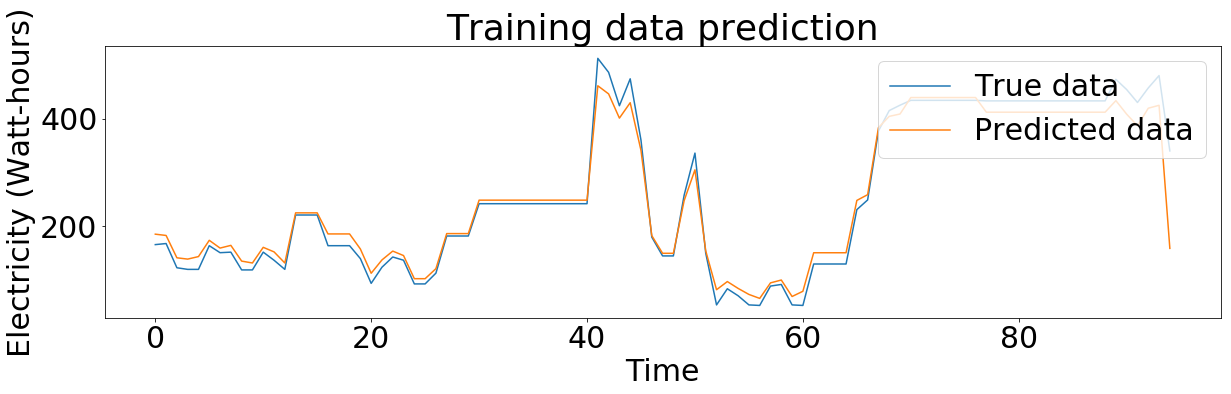

RMSE:  28.832971520247124
NRMSE:  -0.017595064260562145


In [81]:
# Training Data
pred_train_x = model.predict(train_X)
plt.figure(figsize=(20,5)) 
plt.plot(train_y_un_scaled[1:96])
# plt.plot(pred_train_x[1:96])
plt.plot(np.roll(pred_train_x_un_scaled[1:96], -1))
plt.legend(['True data', 'Predicted data'], loc='upper right')
plt.title('Training data prediction')
plt.xlabel('Time')
plt.ylabel('Electricity (Watt-hours)')
plt.show()
rmse_train=np.sqrt(mean_squared_error(train_y_un_scaled, np.roll(pred_train_x_un_scaled, -1)))
print('RMSE: ', rmse_train)
print ('NRMSE: ',((rmse_train-x_min)/(x_max-x_min)))

In [ ]:
model.get_weights()

In [ ]:
model.summary()

In [ ]:
model.get_config()

In [ ]:
model.to_json()

In [ ]:
model.to_yaml()